# **Sentiment Analysis**

## **Imports**

In [2]:
#python -m spacy download de_core_news_sm
from germansentiment import SentimentModel
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from IPython.display import display

## **Sentiment**

### German Sentiment Model

https://huggingface.co/oliverguhr/german-sentiment-bert?text=Da+sisrt+super

## **Sentiment Functions**

In [16]:
def analyze_manifesto_sentiment(manifesto_path, party="NaN"):
    nlp = spacy.load("de_core_news_sm")
    
    with open(manifesto_path, 'r', encoding='utf-8') as file:
        manifesto_text = file.read()

    # Teile den Text in Abschnitte auf
    sections = manifesto_text.split('\n')  

    data = {'Section': [], 'Sentiment': [], 'Score': []}

    model = SentimentModel() 

    for section in sections:
        pred_class, probabilities = model.predict_sentiment([section], output_probabilities=True)
        max_probability = max(probabilities[0], key=lambda x: x[1])[1]

        data['Section'].append(section)
        data['Sentiment'].append(pred_class[0])
        data['Score'].append(max_probability)

    df_sections = pd.DataFrame(data)
    df_sections.to_csv(f'{party}_sentiment_results.csv', index=False)

    print(f"Sentiment for [{manifesto_path}] analized!")

    return df_sections

def plot_sentiment_distribution(df):
    sentiment_counts = df['Sentiment'].value_counts()

    plt.figure(figsize=(8, 6))
    sentiment_counts.plot(kind='bar', color='skyblue')
    plt.title('Sentiment Distribution')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## **CDU CSU**

Sentiment for [../manifestos/cdu_csu_text.txt] analized!


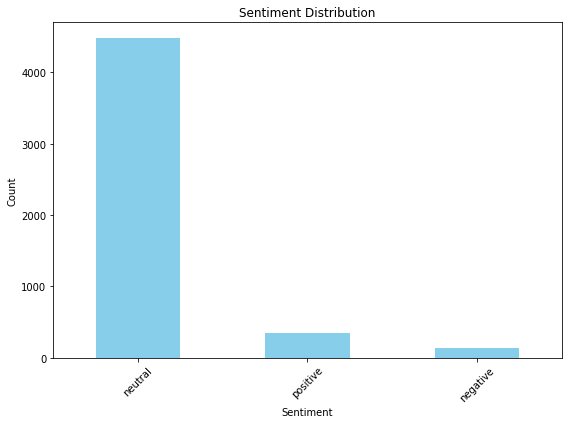

In [19]:
cdu_sentiment = analyze_manifesto_sentiment("../manifestos/cdu_csu_text.txt", "cdu_csu")
plot_sentiment_distribution(cdu_sentiment)

## **SPD**

Sentiment for [../manifestos/spd_text.txt] analized!


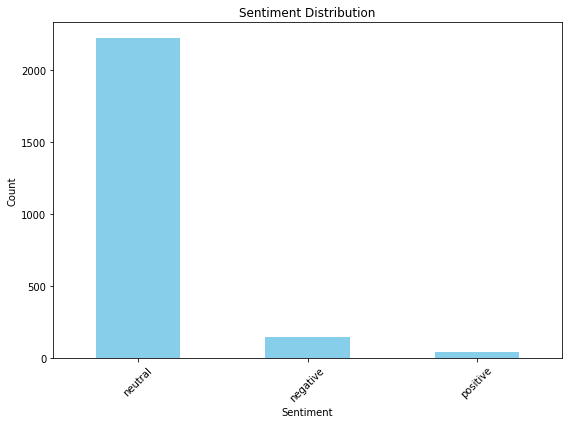

In [20]:
spd_sentiment = analyze_manifesto_sentiment("../manifestos/spd_text.txt", "spd")
plot_sentiment_distribution(spd_sentiment)

## **Die Grünen**

Sentiment for [../manifestos/gruene_text.txt] analized!


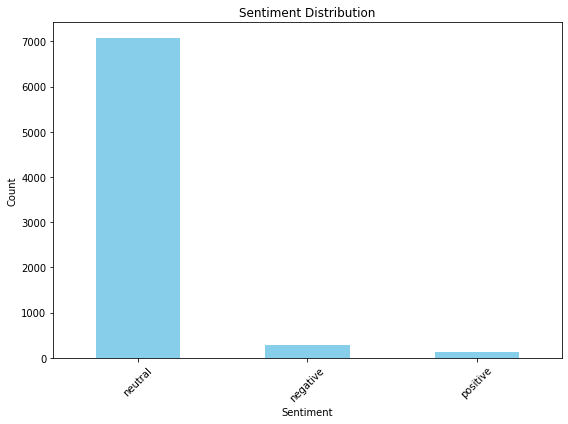

In [21]:
gruen_sentiment = analyze_manifesto_sentiment("../manifestos/gruene_text.txt", "gruene")
plot_sentiment_distribution(gruen_sentiment)

## **FDP**

Sentiment for [../manifestos/fdp_text.txt] analized!


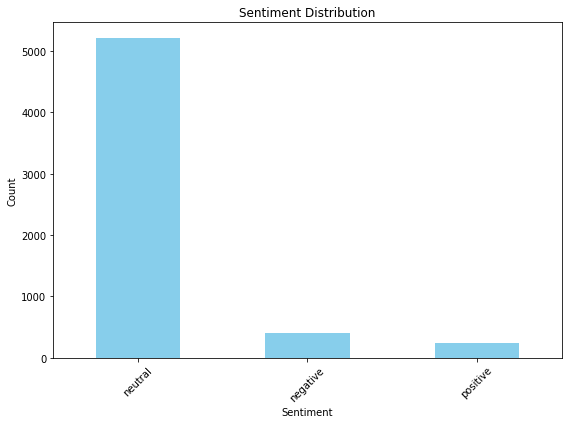

In [22]:
fdp_sentiment = analyze_manifesto_sentiment("../manifestos/fdp_text.txt", "fdp")
plot_sentiment_distribution(fdp_sentiment)

## **AFD**

Sentiment for [../manifestos/afd_text.txt] analized!


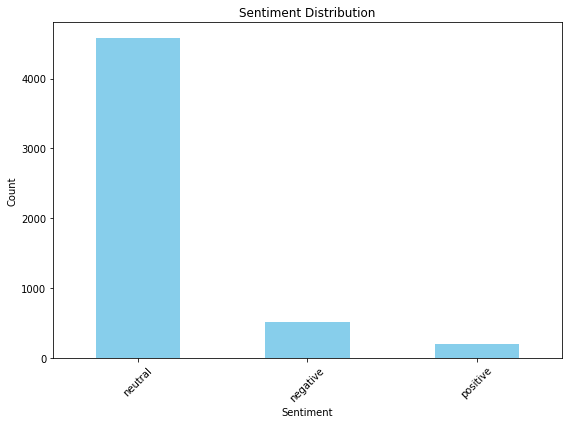

In [23]:
afd_sentiment = analyze_manifesto_sentiment("../manifestos/afd_text.txt", "afd")
plot_sentiment_distribution(afd_sentiment)

## **Linke**

Sentiment for [../manifestos/linke_text.txt] analized!


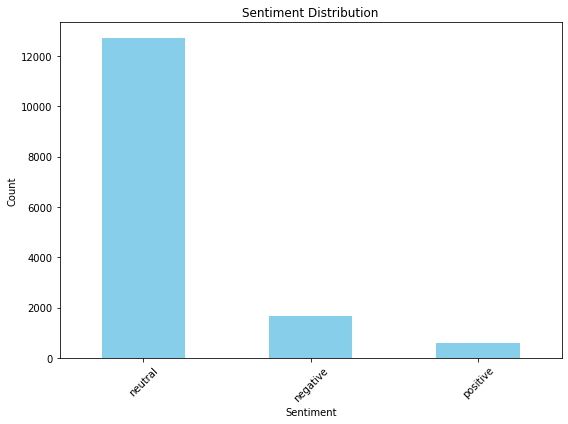

In [25]:
linke_sentiment = analyze_manifesto_sentiment("../manifestos/linke_text.txt", "die_linke")
plot_sentiment_distribution(linke_sentiment)

## **Sentiment characteristics**

In [52]:
def sentiment_characteristics(dataframes:list, parties:list):

    pos_scores = []
    neg_scores = []
    total_sections_overall = []
    
    for df in dataframes:
        sentiment_counts = df['Sentiment'].value_counts()
        sections_total = len(df)
        # 0 -> neutral, 1 -> pos, 2 -> neg
        pos_score = round((sentiment_counts[1] / (sections_total)) * 100,2 )
        neg_score = round((sentiment_counts[2] / (sections_total)) * 100,2 )

        pos_scores.append(pos_score)
        neg_scores.append(neg_score)
        total_sections_overall.append(sections_total)

    sizes = [size / 10 for size in total_sections_overall]

    plt.figure(figsize=(10, 6))
    plt.scatter(pos_scores, neg_scores, color='blue', s=sizes)

    for i, party in enumerate(parties):
        plt.annotate(party, (pos_scores[i], neg_scores[i]), textcoords="offset points", xytext=(0,5), ha='center')

    plt.title('Positiv vs Negativ Sentiment')
    plt.xlabel('Positiv (%)')
    plt.ylabel('Negativ (%)')
    plt.grid(True)
    plt.show()
    
    # csv expoort
    results_df = pd.DataFrame({'Partei': parties, 'Positiv': pos_scores, 'Negativ': neg_scores})

    # Save to CSV
    results_df.to_csv('sentiment_characteristics.csv', index=False)




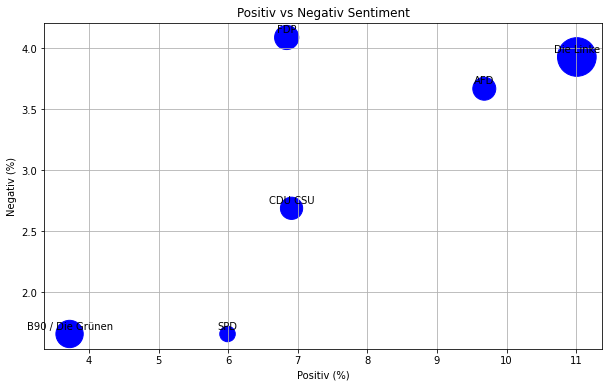

In [53]:
sentiment_dfs = [
    cdu_sentiment,
    spd_sentiment,
    gruen_sentiment,
    fdp_sentiment,
    afd_sentiment,
    linke_sentiment
]

parties = [
    "CDU CSU",
    "SPD",
    "B90 / Die Grünen",
    "FDP",
    "AFD",
    "Die Linke"
]

sentiment_characteristics(sentiment_dfs, parties)

In [26]:
"""
for index, row in cdu_sentiment.iterrows():
    sentiment = row['Sentiment']
    paragraph = row['Section']

    if sentiment == 'positive':
        color = 'green'
    elif sentiment == 'negative':
        color = 'red'
    else:
        color = 'black'

    display(HTML(f'<font color="{color}">{paragraph}</font>'))
"""

'\nfor index, row in cdu_sentiment.iterrows():\n    sentiment = row[\'Sentiment\']\n    paragraph = row[\'Section\']\n\n    if sentiment == \'positive\':\n        color = \'green\'\n    elif sentiment == \'negative\':\n        color = \'red\'\n    else:\n        color = \'black\'\n\n    display(HTML(f\'<font color="{color}">{paragraph}</font>\'))\n'